In [1]:
#Загрузка библиотек
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,TweedieRegressor,SGDRegressor,ElasticNetCV
from sklearn.linear_model import OrthogonalMatchingPursuit,OrthogonalMatchingPursuitCV,BayesianRidge,ARDRegression
from sklearn.linear_model import PassiveAggressiveRegressor,HuberRegressor, TheilSenRegressor,RANSACRegressor,Ridge

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
data_all = pd.ExcelFile("ebw_data.xlsx").parse(0)
data_all = data_all.astype(float)



In [3]:
#нормализация данных
scaler = StandardScaler()
data_all_scale=pd.DataFrame(scaler.fit_transform(data_all),columns=data_all.columns)


In [4]:

data_all_scale.head()

,IW,IF,VW,FP,Depth,Width
0,0.8,-0.456630,-2.02221,0.078087,1.809490,2.055551
1,0.8,-0.456630,-2.02221,0.078087,1.898971,1.911196
2,0.8,-0.456630,-2.02221,0.078087,2.167411,2.272083
3,0.8,-0.456630,-2.02221,0.078087,1.720010,1.983373
4,-0.4,-0.260931,-2.02221,0.078087,2.525333,1.839019


In [5]:
#Разделение данных на входные и целевые
data_check=data_all_scale[['Depth','Width']]
data_work=data_all_scale.drop(data_check.columns.to_list(),axis=1)


<AxesSubplot:>

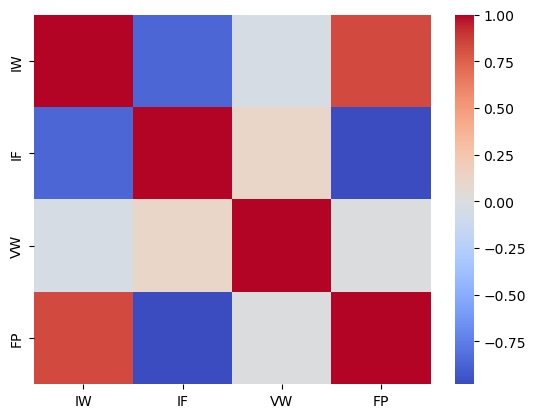

In [6]:
#Выведение информации о данных
sns.heatmap(data_work.corr(), cmap= 'coolwarm')

In [7]:
data_work.corr()

,IW,IF,VW,FP
IW,1.000000,-0.861073,-0.043430,0.835530
IF,-0.861073,1.000000,0.115093,-0.980562
VW,-0.043430,0.115093,1.000000,-0.001060
FP,0.835530,-0.980562,-0.001060,1.000000


In [8]:
data_all.describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


In [9]:
print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     float64
 1   IF      72 non-null     float64
 2   VW      72 non-null     float64
 3   FP      72 non-null     float64
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(6)
memory usage: 3.5 KB
None


In [10]:
# Проверка на не заполненные значения
print(data_all.isna().sum())

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64


In [11]:
data_work.shape

(72, 4)

In [12]:
data_work.corr()

,IW,IF,VW,FP
IW,1.000000,-0.861073,-0.043430,0.835530
IF,-0.861073,1.000000,0.115093,-0.980562
VW,-0.043430,0.115093,1.000000,-0.001060
FP,0.835530,-0.980562,-0.001060,1.000000


In [13]:
#делим данные на тренировочные и проверочные
x_train,x_test,y_train,y_test=train_test_split(data_work,data_check, test_size=0.1)


In [14]:
#таблица итоговая по различным моделям регресии
columns=['Model','Train score R2','Test score R2','Depth R2','Width R2']



In [15]:
def CalculateRegression(model,x_tr,y_tr,x_ts,y_ts):
    line=[model]
    model.fit(x_tr,y_tr)
    prediction=model.predict(x_ts)
    train_score=model.score(x_tr,y_tr)
    test_score=model.score(x_ts,y_ts)
    errR2=r2_score(y_ts,prediction,multioutput='raw_values')
    line.append(train_score)
    line.append(test_score)
    line.extend(errR2)
    return line

In [16]:
def CalculateMultiplyRegression(model,x_tr,y_tr,x_ts,y_ts):
    line=[model]
    mods=MultiOutputRegressor(model)
    mods.fit(x_tr,y_tr)
    prediction=mods.predict(x_ts)
    train_score=mods.score(x_tr,y_tr)
    test_score=mods.score(x_ts,y_ts)
    errR2=r2_score(y_ts,prediction,multioutput='raw_values')
    line.append(train_score)
    line.append(test_score)
    line.extend(errR2)    
    return line

In [18]:
#Модели регресий которые проверяем
regres_model_m=[LinearRegression(),
                KNeighborsRegressor(),
                RandomForestRegressor(n_estimators=100, max_features='sqrt'),
                OrthogonalMatchingPursuit(normalize=False),
                Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)           
               ]
regres_model=[SVR(kernel='linear'),
              GradientBoostingRegressor(n_estimators=1000,learning_rate=0.1),
              TweedieRegressor(power=0, alpha=1,max_iter=1000),
              SGDRegressor(max_iter=10000, tol=1e-3),
              ElasticNetCV(cv=5, random_state=0),
              OrthogonalMatchingPursuitCV(normalize=False),
              BayesianRidge(),
              ARDRegression(),
              PassiveAggressiveRegressor(),
              HuberRegressor(),
              TheilSenRegressor(random_state=42),
              RANSACRegressor(random_state=42)
               ]


In [19]:
%%time
#Модели регрессии проверяем


result_table=pd.DataFrame(columns=columns)
for i in regres_model_m:
    result=CalculateRegression(i,x_train,y_train,x_test,y_test)
    result_table.loc[ len(result_table.index )]=result
    
for i in regres_model:
    result=CalculateMultiplyRegression(i,x_train,y_train,x_test,y_test)
    result_table.loc[ len(result_table.index )]=result
    


Wall time: 700 ms


In [20]:
%%time
#Формируем нейросеть
model = Sequential()
model.add(Dense(x_train.shape[1],   activation='tanh'))
model.add(Dense(10,  activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(30,  activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(10,  activation='tanh'))
model.add(Dense(2,  activation='linear'))
model.compile(loss = 'mse',optimizer=Adam(learning_rate=0.001),metrics = ['accuracy','mse','mae'])
history=model.fit(x_train,y_train, batch_size=(x_train.shape[1]), epochs=300,  verbose =0, validation_data=(x_test,y_test))
    
results = model.evaluate(x_train, y_train)
print('train loss, train acc:', results)
results = model.evaluate(x_test, y_test)
print('test loss, test acc:', results)

test_pred = model.predict(x_test)
train_pred = model.predict(x_train)
errR2=r2_score(y_train,train_pred,multioutput='raw_values')
print("Вычисляем для train R2:",errR2)
errR2=r2_score(y_test,test_pred,multioutput='raw_values')
print("Вычисляем для test R2:",errR2)


2/2 [==============================] - 0s 7ms/step - loss: 0.0650 - accuracy: 0.9531 - mse: 0.0650 - mae: 0.1907
train loss, train acc: [0.06500592082738876, 0.953125, 0.06500592082738876, 0.1906592696905136]
1/1 [==============================] - 0s 21ms/step - loss: 0.0754 - accuracy: 0.8750 - mse: 0.0754 - mae: 0.2340
test loss, test acc: [0.07540382444858551, 0.875, 0.07540382444858551, 0.2340298295021057]
2/2 [==============================] - 0s 3ms/step
Вычисляем для train R2: [0.89992087 0.96595112]
Вычисляем для test R2: [0.88125153 0.97657083]
Wall time: 29.9 s


In [21]:
line=['Neural network ']
line.append(r2_score(y_train,train_pred))
line.append(r2_score(y_test,test_pred))
line.extend(r2_score(y_test,test_pred,multioutput='raw_values'))    
result_table.loc[ len(result_table.index )]=line


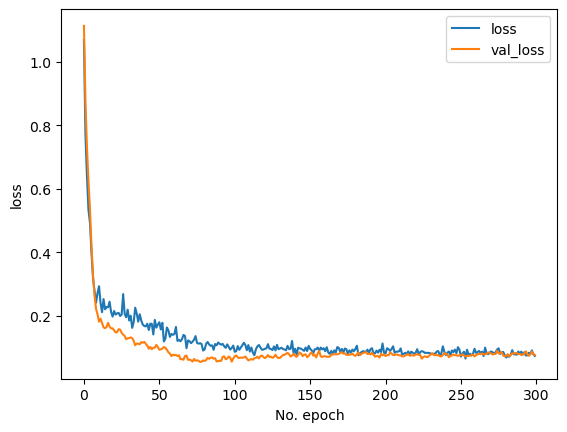

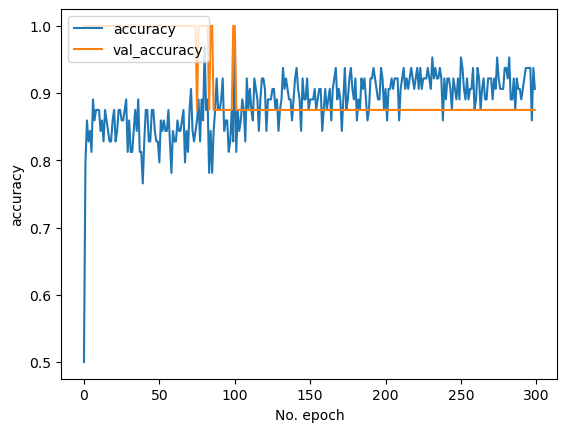

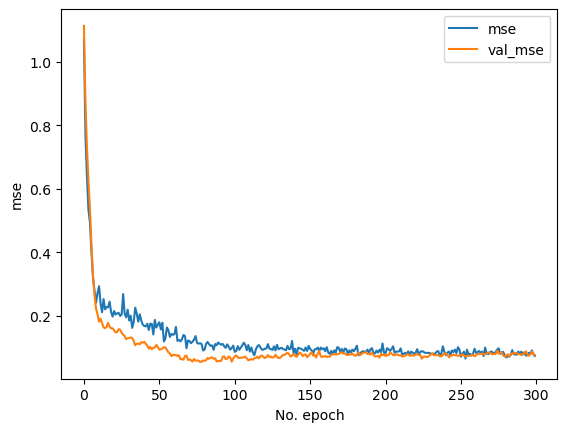

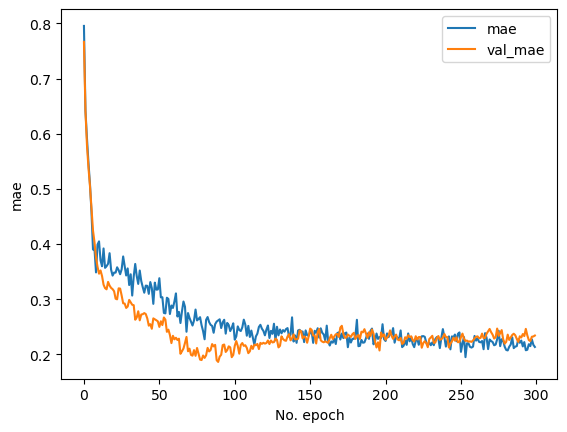

In [22]:
#Выводим дынне как обучалась нейросеть
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label='val_mse')
#plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('mse')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
#plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('mae')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()


In [23]:
#информация о модели
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 10)                50        
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                330       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                310       
                                                                 
 dense_4 (Dense)             (None, 2)                 2

In [24]:
# Итоговая таблица с результатми всех вычислений
result_table_=result_table.sort_values(['Test score R2','Train score R2'],ascending=[False,False])
result_table_

,Model,Train score R2,Test score R2,Depth R2,Width R2
1,KNeighborsRegressor(),0.940561,0.952143,0.912724,0.991563
2,"(DecisionTreeRegressor(max_features='sqrt', ra...",0.953200,0.940439,0.903138,0.977740
6,GradientBoostingRegressor(n_estimators=1000),0.953456,0.940363,0.904166,0.976561
17,Neural network,0.932936,0.928911,0.881252,0.976571
12,ARDRegression(),0.867454,0.909126,0.855290,0.962961
10,OrthogonalMatchingPursuitCV(normalize=False),0.868045,0.907456,0.851884,0.963028
0,LinearRegression(),0.868133,0.906903,0.851884,0.961922
9,"ElasticNetCV(cv=5, random_state=0)",0.867811,0.906411,0.850760,0.962062
11,BayesianRidge(),0.867159,0.905629,0.849508,0.961750
8,SGDRegressor(max_iter=10000),0.810716,0.890260,0.830574,0.949946
